# 자동차 연비 예측하기: 회귀

### 텐서플로와 다른 라이브러리 임포트

In [1]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
!pip install seaborn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


In [3]:
# 런타임에서 할당하는데 필요한 양만큼의 GPU 메모리를 할당
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

### Auto MPG 데이터셋 로딩

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path #/root/.keras/datasets/auto-mpg.data 여기로 다운로드됨

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

In [5]:
#pandas로 데이터 읽기
#https://codedragon.tistory.com/9418
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
# target은 MPG로, 나머지 속성 7가지는 input 값으로 사용된다.

# read_cvs 함수 = csv파일을 읽어 pandas 기본 데이터 구조인 dataFrame으로 만들어줌
# read_cvs 옵션: names[불러올때 칼럼 이름을 지정한 이름으로 변경]
#                na_values[특정 값을 NaN으로 취급하고 싶을때 사용, 여기서는 "?"값을 NaN으로 취급하라는 것]
#                sep[데이터를 구분하는 구분자]
#                skipinitialspace[앞부분에 space가 있으면 그냥 skip해라]   
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy() 
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 전처리

#### Q. 누락데이터 확인해서 제거하시오. (Hint : 누락 데이터 확인은 dataset.isna()으로 확인)

In [6]:
# 누락 데이터 확인은 dataset.isna()로 확인
print(dataset.isna()) #누락 데이터 조회
print(dataset.isna().sum())# 누락 데이터 개수 합산 -> 어떤 column에 누락데이터 있는지 보여줌
dataset = dataset.dropna()# 누락 데이터 제거
print(dataset) 

       MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
0    False      False         False  ...         False       False   False
1    False      False         False  ...         False       False   False
2    False      False         False  ...         False       False   False
3    False      False         False  ...         False       False   False
4    False      False         False  ...         False       False   False
..     ...        ...           ...  ...           ...         ...     ...
393  False      False         False  ...         False       False   False
394  False      False         False  ...         False       False   False
395  False      False         False  ...         False       False   False
396  False      False         False  ...         False       False   False
397  False      False         False  ...         False       False   False

[398 rows x 8 columns]
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weig

#### Origin을 이용해서 One-Hot Vector 형태의 세개의 컬럼을 생성 ( 1은 USA, 2는 Europe, 3은 Japan)

In [7]:
# 누락된 데이터 열은 수치형 x -> binary column으로 변경
origin = dataset.pop('Origin') # 1은 USA, 2는 Europe, 3은 Japan
#pop하면 이름에 해당되는 column부분을 꺼내 return한다

# 즉 orgin에서 1을 나타내는건 USA, 2는 Europe, 3은 Japen을 의미함 이를 one-hot vector형태로 하기 위해서는
# USA는 [1,0,0]이런식으로 바꿔줘야 한다

dataset['USA'] = (origin == 1)*1.0 # 논리연산 * 1.0
dataset['Europe'] = (origin == 2)*1.0 # 논리연산 * 1.0
dataset['Japan'] = (origin == 3)*1.0 # 논리연산 * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


#### Q. 데이터셋을 훈련 세트와 테스트 세트로 분할하시오. (Hint : dataset.sample(), dataset drop() 사용)

In [9]:
# 데이터 샘플링 -> dataset.sample
#sample함수 = 객체 내에서 랜덤으로 샘플 추출한다
# smaple함수 옵션: n[추출할 샘플의 수], frac[비율을 주면 그 비율 만큼 개수 만큼 샘플 추출]
#                  random_state[랜덤 샘플 추출 시 시드를 입력 받어, 같은 시드에서는 항상 같은 결과 도출한다]

#drop함수는 dataframe의 행 또는 열을 삭제할 수 있다.
train_dataset = dataset.sample(frac=0.8, random_state=0) # 먼저 dataset.sample로 랜덤으로 데이터 개수 추출한다(frac이용)
test_dataset = dataset.drop(train_dataset.index)# train_dataset에서 뽑은 샘플들을 제거한 나머지 0.2에 해당되는 데이터만 얻는다
#drop은 defatult로 axis=0이므로 row 제거

#### 산점도 행렬로 데이터 분포 및 상관성 조사

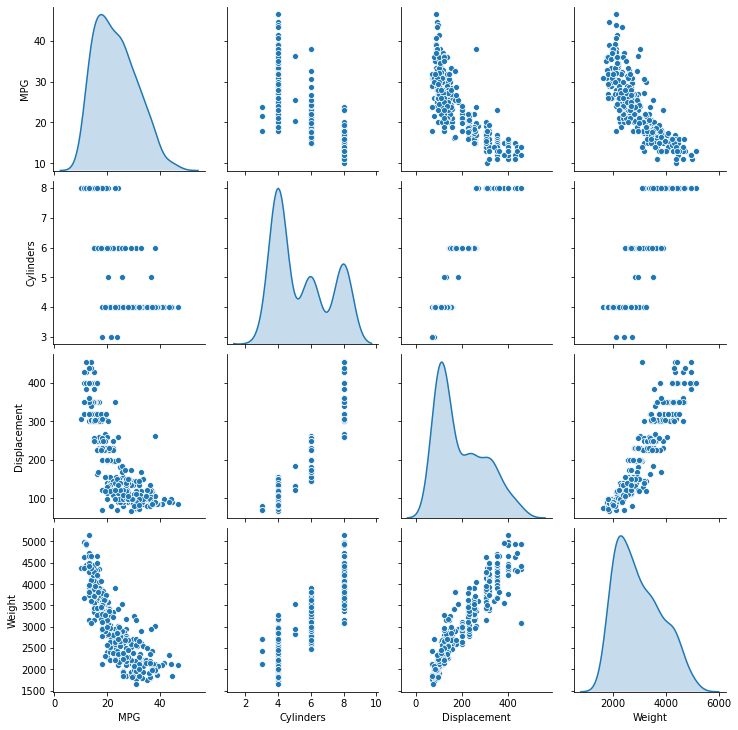

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

#### 통계 확인

In [11]:
#https://dandyrilla.github.io/2017-08-12/pandas-10min/

#describe함수는 DataFrame의 간단한 통계 정보를 보여준다.
# 컬럼별로 데이터 개수, 평균값, 표준편차, 최솟값, 4분위수, 최댓값의 정보를 알 수 있다 -> 평균과 표준편차를 이용해 정규화를 할 수 있다
train_stats = train_dataset.describe()
train_stats.transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### Q. 훈련 세트와 테스트 세트의 레이블 분리하시오. (Hint : dataset.pop() 사용)

In [13]:
# dataset.pop() 사용 -> 우리가 원하는 결과의 정보는 MPG이댜
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

####  데이터 정규화 
표준정규분포 정규화 사용 $z = \frac{X - \mu}{\sigma} \sim \mathcal{N}(0,1)$

In [14]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']


# DataFrame연산 : 같은 인덱스를 가진 항목끼리 연산 한다!
# 그래서 위에서 label을 뺀 train_stat["means"]와 train_stat["std"]의 column은 {Cylinders: {…}, Displacement: {….}, Weight: {…}, …} 이다
# train_dataset의 column은 {MPG:{…}, Cylinders: {…}, Weight: {…}, …}으로 "weight"의 인덱스가 같다
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [15]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852


### 모델

#### Q. 모델을 생성하는 build_model() 함수를 정의하시오.

In [17]:
# network에서 input layer은 train_label부분인 Cylinders , Displacement , Horsepower , .., Japan으로 9*1이다
# network는 2-hidden layer를 가진다 각 hidden layer에서 뉴런의 수는 64개이고, activation function은 relu이다
# network에서 output layer는 1*1형태로 연비(MPG)를 예측하는 네트워크이다!

def build_model():
  # input len(train_dataset.keys()) 
  # hidden 64, hidden 64, output 1
  model = keras.Sequential([
        keras.layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]), #input layer는 train_dataset의 len이다
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1) #output layer는 1차원, 출력 계층의 activation function은 현재 회귀문제이므로 항등함수를 사용하면 된다.
  ])

  # RMSProp으로 Optimizer 생성, learning rate = 0.001
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  # loss, oprimizer, metric 설정
  # metric은 'mean_absolute_error’, 'mean_squared_error'로 설정
  # 현재 회귀문제이기 때문에 loss :mean_squared_error, metrics: mean_absolute_error, mean_squared_error
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error','mean_squared_error'])
  return model

In [18]:
model = build_model()

In [19]:
# 모델 구조를 출력하는 함수
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 훈련 전 미리 10개의 데이터에 대해 예측 결과
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.5606861 ],
       [-0.27747723],
       [-0.48501414],
       [-0.5952355 ],
       [-0.6283715 ],
       [-0.14942335],
       [-0.687158  ],
       [-0.27234027],
       [-0.2460405 ],
       [-0.30842006]], dtype=float32)

### 모델 훈련

#### Q. 모델을 훈련시키기 위해 model.fit() 함수를 완성하시오.
1. PrintDot() Callback 추가
2. validation_split을 이용해서 validation set은 training set의 20%로 설정
3. verbose=0로 설정해서 출력 없애기

In [21]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('') # 한줄에 100개 점이 생기면 엔터
    print('.', end='')

EPOCHS = 1000

# 1. PrintDot() Callback 추가
# 2. validate_split을 이용해서 validation set은 training set의 20%로 설정
# 3. verbose=0로 설정해서 출력 없애기
history = model.fit(normed_train_data, train_labels,
                    epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### 훈련 과정 시각화

In [22]:
hist = pd.DataFrame(history.history) # 모델의 history table 출력
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.485144,0.996724,2.485144,9.386266,2.333623,9.386266,995
996,2.551550,0.997584,2.551550,8.809591,2.263284,8.809591,996
997,2.477616,0.961567,2.477616,9.267565,2.311220,9.267565,997
998,2.794611,1.096002,2.794611,9.019004,2.290402,9.019004,998
999,2.399653,0.967442,2.399653,9.540120,2.370238,9.540120,999


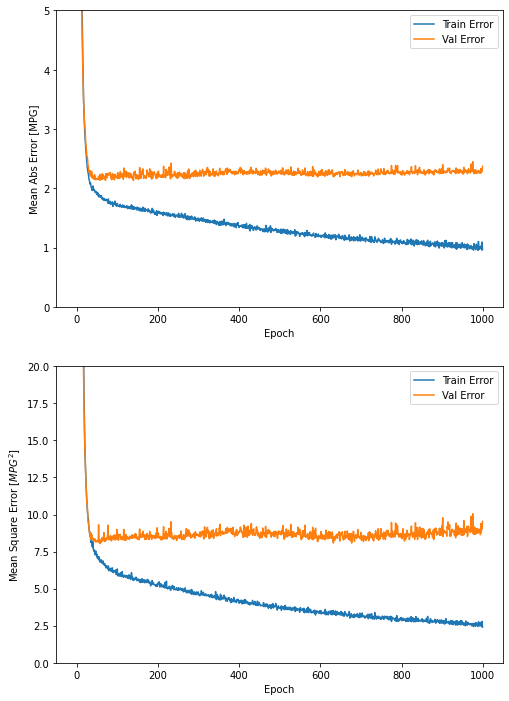

In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

## 검증

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.9858 - mean_absolute_error: 1.8331 - mean_squared_error: 5.9858
테스트 세트의 평균 절대 오차:  1.83 MPG


## 예측

#### 예측 테스트 결과와 실제 레이블과의 상관 관계 그래프

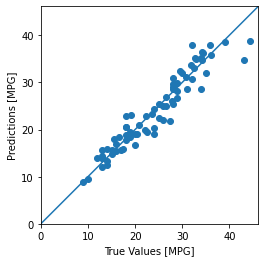

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

#### 오차 분포 히스토그램

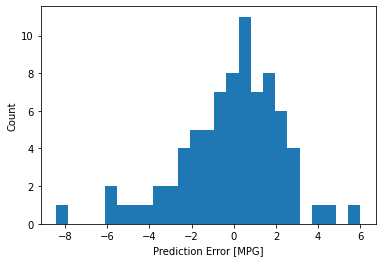

In [26]:
# 오차의 분포
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

 훈련 시 early stopping할 수 있도록 callback을 추가하시오.

In [27]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000


# keras.callbacks.EarlyStopping 사용
# patience : 성능 향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


..

In [28]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.1718 - mean_absolute_error: 1.9541 - mean_squared_error: 6.1718
테스트 세트의 평균 절대 오차:  1.95 MPG


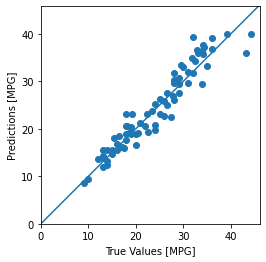

In [29]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal') # 각 축의 스케일을 동일하게 함
plt.axis('square') # # 각 축의 범위가 xmax - xmin = ymax - ymin이 되게 설정
plt.xlim([0,plt.xlim()[1]]) # 0부터 시작하도록 범위 조절
plt.ylim([0,plt.ylim()[1]]) # 0부터 시작하도록 범위 조절
_ = plt.plot([-100, 100], [-100, 100])